In [1]:
#%pip install -U -q "google-generativeai>=0.8.3"
import typing_extensions as typing
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
genai.configure(api_key='')
from typing_extensions import TypedDict, List
import json
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the output schema (without date)
class ThreatParser(TypedDict):
    description: str
    country_of_origin: List[str]
    country_of_target: List[str]
    energy_related: bool

# Instantiate the generative model
model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=ThreatParser,
    )
)

# Input and output filepaths
input_filepath = "datasets/malpedia_actors.json"  # Adjust this filename to your actual input JSON
output_filepath = "malpedia_output.json"

def parse_threat_data(input_filepath, output_filepath):
    # Load the input JSON file; assume its structure is a dict with threat actor keys.
    try:
        with open(input_filepath, 'r') as f:
            data = json.load(f)
        # Convert the threat items into a list (each value is a threat actor object)
        threat_values = list(data.values())
    except Exception as e:
        print(f"Error reading the input JSON: {e}")
        return

    # Load existing results if the output file exists
    try:
        with open(output_filepath, 'r') as f:
            parsed_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        parsed_data = []

    # Use the description field from previous results to avoid duplicate processing
    processed_descriptions = {item["description"] for item in parsed_data}

    # Open the output file in write mode to save intermediate results
    with open(output_filepath, 'w') as f:
        for index, item in enumerate(tqdm(threat_values, desc="Processing threats")):
            # Extract and clean the description from the threat item
            description_text = str(item.get("description", "")).strip()
            if not description_text or description_text in processed_descriptions:
                continue  # Skip if no description or already processed

            # Generate content using the Gemini AI model
            response = model.generate_content(description_text)
            time.sleep(7)  # Delay to avoid rapid API calls

            try:
                parsed_item = json.loads(response.text)
                # Store the original description in the parsed result
                parsed_item["description"] = description_text
                print(parsed_item)
            except json.JSONDecodeError as e:
                print(f"Error parsing Gemini API response: {e}\nDescription: {description_text}")
                parsed_item = {
                    "description": description_text,
                    "error": "Gemini API parsing failed"
                }

            parsed_data.append(parsed_item)
            # Save intermediate results
            f.seek(0)
            json.dump(parsed_data, f, indent=4)
            f.truncate()

    print(f"Parsed data written to {output_filepath}")

# Uncomment the line below to run the parsing process.
#parse_threat_data(input_filepath, output_filepath)


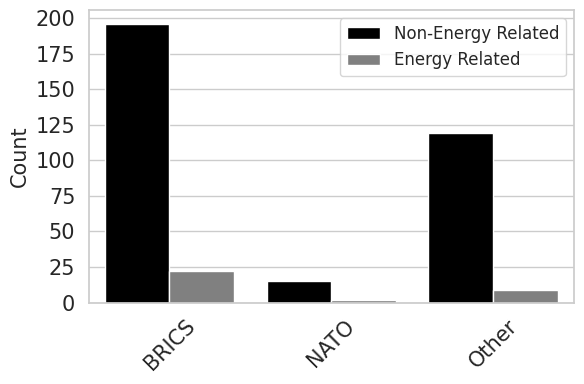

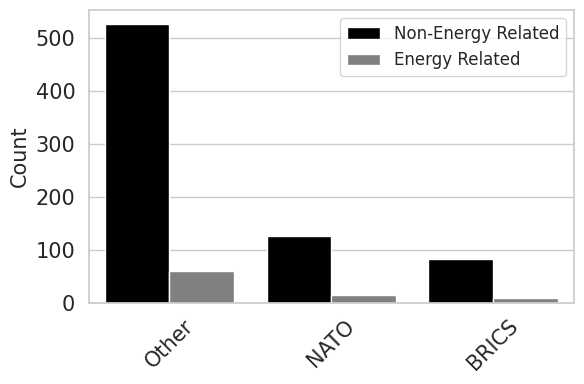

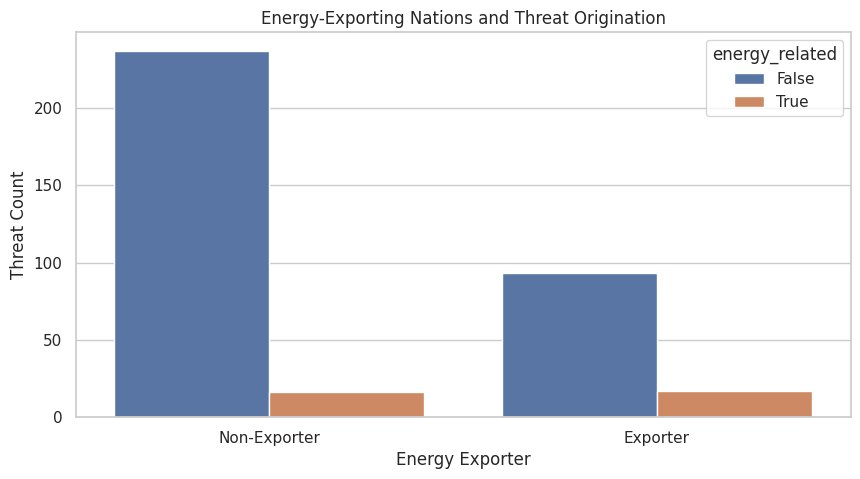

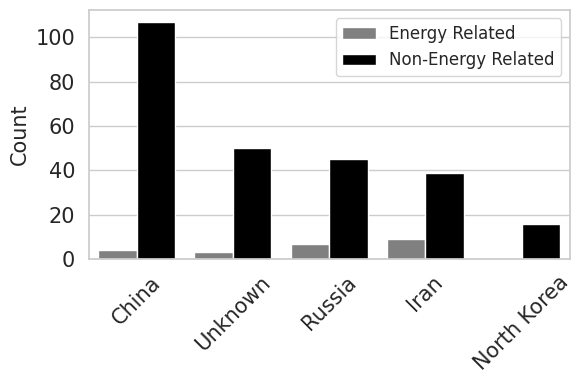

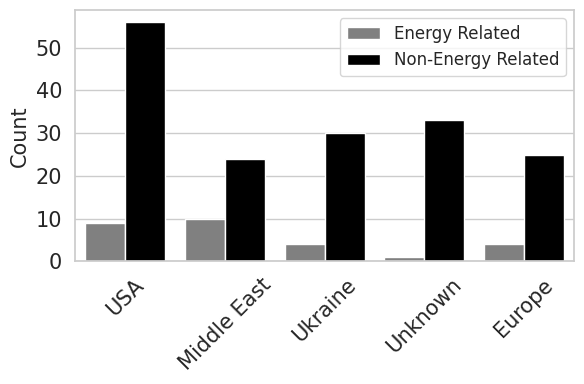

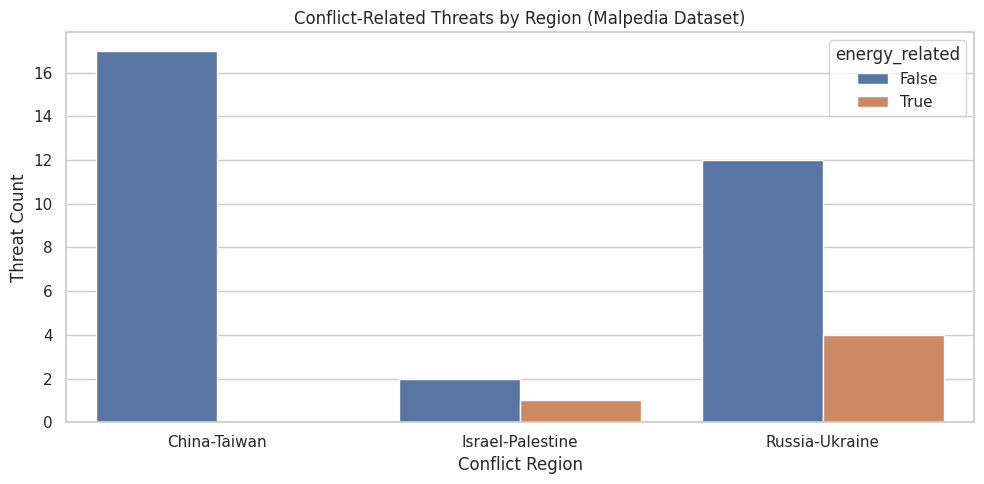

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# =============================================================================
# File and Data Loading
# =============================================================================

# Update the file path to point to your Malpedia JSON data
data_filepath = "malpedia_output.json"

def load_parsed_data(filepath):
    """Load JSON data from a file. Returns an empty list on error."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading parsed JSON: {e}")
        return []

data = load_parsed_data(data_filepath)

# =============================================================================
# Mappings and Helper Functions
# =============================================================================

# Standardized country names mapping
country_aliases = {
    "United States": "USA",
    "U.S.": "USA",
    "US": "USA",
    "U.S.A.": "USA",
    "America": "USA",
    "United Kingdom": "UK",
    "Great Britain": "UK",
    # You can add more aliases as needed
}

# Country flag emojis mapping (or country codes used for flag lookup)
flag_emojis = {
    "USA": "US",
    "UK": "GB",
    "Russia": "RU",
    "Ukraine": "UA",
    "Israel": "IL",
    "Palestine": "PS",
    "China": "CN",
    "Taiwan": "TW"
}

def standardize_country_name(country):
    """
    Standardize a country name.
    If the value (after stripping) is "null", "unknown" or "string" (case-insensitive),
    return "Unknown". Otherwise, use the country_aliases mapping.
    """
    if not isinstance(country, str):
        return "Unknown"
    c = country.strip()
    if c.lower() in ["null", "unknown", "string"]:
        return "Unknown"
    return country_aliases.get(c, c)

def get_flag_emoji(country):
    """Return a flag emoji (or country code) based on the country name."""
    return flag_emojis.get(country, country)

def ensure_list_fields(data_item):
    """Ensure the data item has valid list entries for country fields."""
    if "energy_related" not in data_item:
        data_item["energy_related"] = False
    if "country_of_origin" not in data_item or not isinstance(data_item["country_of_origin"], list):
        data_item["country_of_origin"] = []
    if "country_of_target" not in data_item or not isinstance(data_item["country_of_target"], list):
        data_item["country_of_target"] = []

# Ensure every item has the necessary fields
for item in data:
    ensure_list_fields(item)

# =============================================================================
# Analysis Functions
# =============================================================================

def analyze_geopolitical_alignments(data):
    """Analyze threats by geopolitical alliances (NATO, BRICS, or Other)."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")

    alliances = {
        "NATO": [
            "Albania", "Belgium", "Bulgaria", "Canada", "Croatia", "Czechia", "Denmark",
            "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland",
            "Italy", "Latvia", "Lithuania", "Luxembourg", "Montenegro", "Netherlands",
            "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Slovakia",
            "Slovenia", "Spain", "Sweden", "Türkiye", "UK", "USA"
        ],
        "BRICS": [
            "China", "Russia", "India", "Brazil", "South Africa", "Egypt",
            "Ethiopia", "Indonesia", "Iran", "United Arab Emirates"
        ],
    }
    
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    # Explode country_of_origin
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_exploded = df.explode("country_of_origin")
    
    # Standardize names, remove empty or NaN
    df_exploded["country_of_origin"] = df_exploded["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_exploded = df_exploded.dropna(subset=["country_of_origin"])
    
    # Determine alliance membership
    def find_alliance(country):
        for a, members in alliances.items():
            if country in members:
                return a
        return "Other"
    
    df_exploded["alliance"] = df_exploded["country_of_origin"].apply(find_alliance)
    
    # Map boolean to strings so we can match the style from your other plots
    df_exploded["energy_status"] = df_exploded["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot in a similar style to 'analyze_threat_origins_targets'
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_exploded,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    
    # Remove big title, adjust legend and axes to match style
    plt.legend(title="", fontsize=12)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    plt.savefig("alliances_origin_malpedia.pdf")
    plt.show()

    ######
    # ---- Threat Targets ----
    # Ensure each entry in "country_of_target" is a list.
    df["country_of_target"] = df["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    # Explode the list so that each row corresponds to a single target country.
    df_exploded = df.explode("country_of_target")
    
    # Standardize country names and filter out empty or NaN values.
    df_exploded["country_of_target"] = df_exploded["country_of_target"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_exploded = df_exploded.dropna(subset=["country_of_target"])
    
    # Determine alliance membership based on the target country.
    def find_alliance(country):
        for alliance_name, members in alliances.items():
            if country in members:
                return alliance_name
        return "Other"
    
    df_exploded["alliance"] = df_exploded["country_of_target"].apply(find_alliance)
    
    # Map the boolean energy flag to a string for labeling.
    df_exploded["energy_status"] = df_exploded["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot in a similar style to your origins plot.
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_exploded,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    
    # Adjust labels and legend to match the style.
    plt.legend(title="", fontsize=12)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    
    plt.tight_layout()
    plt.savefig("alliances_targets_malpedia.pdf")
    plt.show()

    


def analyze_energy_export_dependence(data):
    """Analyze threats with respect to energy-exporting countries."""
    energy_exporters = ["Russia", "Saudi Arabia", "Iran", "Venezuela", "USA", "Canada"]
    
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    # Explode the country_of_origin column
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_exploded = df.explode("country_of_origin")
    
    df_exploded["country_of_origin"] = df_exploded["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_exploded = df_exploded.dropna(subset=["country_of_origin"])
    df_exploded = df_exploded[df_exploded["country_of_origin"] != ""]
    
    # Flag if the origin country is an energy exporter
    df_exploded["energy_exporter"] = df_exploded["country_of_origin"].apply(lambda x: x in energy_exporters)
    
    plt.figure(figsize=(10, 5))
    order = df_exploded["energy_exporter"].value_counts().index
    sns.countplot(data=df_exploded, x="energy_exporter", hue="energy_related", order=order)
    plt.title("Energy-Exporting Nations and Threat Origination")
    plt.xlabel("Energy Exporter")
    plt.ylabel("Threat Count")
    plt.xticks(ticks=[0, 1], labels=["Non-Exporter", "Exporter"])
    plt.show()


def analyze_threat_origins_targets(data):
    """Analyze and compare the origins and targets of threats for energy vs. general events.
    For both origins and targets, the top 5 countries (by total incident count) are shown,
    with a breakdown into energy-related and non-energy-related detections.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")
    
    df = pd.DataFrame(data)
    df["energy_related"] = df["energy_related"].astype(bool)
    
    #### Threat Origins ####
    df_origin = df.copy()
    # Ensure each entry in "country_of_origin" is a list.
    df_origin["country_of_origin"] = df_origin["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df_origin = df_origin.explode("country_of_origin")
    df_origin["country_of_origin"] = df_origin["country_of_origin"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_origin = df_origin.dropna(subset=["country_of_origin"])
    df_origin = df_origin[df_origin["country_of_origin"] != ""]
    
    # Aggregate by country: get total count and counts for energy-related True and False.
    origin_agg = df_origin.groupby("country_of_origin").agg(
        total=("country_of_origin", "count"),
        energy_true=("energy_related", lambda x: (x==True).sum()),
        energy_false=("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Select the top 5 countries by total incident count.
    top5_origin = origin_agg.sort_values("total", ascending=False).head(5)
    
    # Melt the data so that each country appears twice (once for each energy status).
    top5_origin_melt = top5_origin.melt(id_vars=["country_of_origin", "total"],
                                         value_vars=["energy_true", "energy_false"],
                                         var_name="energy_status",
                                         value_name="count")
    top5_origin_melt["energy_status"] = top5_origin_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    plt.figure(figsize=(6, 4))
    ax1 = sns.barplot(data=top5_origin_melt, 
                      x="country_of_origin", 
                      y="count", 
                      hue="energy_status", 
                      palette={"Energy Related": "grey", "Non-Energy Related": "black"},
                      order=top5_origin.sort_values("total", ascending=False)["country_of_origin"])
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig("origins_malpedia.pdf")
    plt.show()
    
    #### Threat Targets ####
    df_target = df.copy()
    # Ensure each entry in "country_of_target" is a list.
    df_target["country_of_target"] = df_target["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    df_target = df_target.explode("country_of_target")
    df_target["country_of_target"] = df_target["country_of_target"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_target = df_target.dropna(subset=["country_of_target"])
    df_target = df_target[df_target["country_of_target"] != ""]
    
    # Aggregate by target country.
    target_agg = df_target.groupby("country_of_target").agg(
        total=("country_of_target", "count"),
        energy_true=("energy_related", lambda x: (x==True).sum()),
        energy_false=("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Select the top 5 countries by total incident count.
    top5_target = target_agg.sort_values("total", ascending=False).head(5)
    
    # Melt the target data.
    top5_target_melt = top5_target.melt(id_vars=["country_of_target", "total"],
                                         value_vars=["energy_true", "energy_false"],
                                         var_name="energy_status",
                                         value_name="count")
    top5_target_melt["energy_status"] = top5_target_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    plt.figure(figsize=(6, 4))
    ax2 = sns.barplot(data=top5_target_melt, 
                      x="country_of_target", 
                      y="count", 
                      hue="energy_status", 
                      palette={"Energy Related": "grey", "Non-Energy Related": "black"},
                      order=top5_target.sort_values("total", ascending=False)["country_of_target"])
    #plt.title("Top 5 Threat Targets by Count", fontsize=16)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig("targets_malpedia.pdf")
    plt.show()


def analyze_conflict_related_threats(data):
    """
    Analyze threats related to ongoing conflicts.
    For the Malpedia dataset (which lacks dates) we define an event as conflict-related
    if both the country of origin and target belong to a predefined conflict region.
    Instead of a timeline plot, we group by conflict region and plot the counts.
    """
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }
    
    df = pd.DataFrame(data)
    
    # Ensure the country fields are lists and then explode them
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
    df["country_of_target"] = df["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
    df = df.explode("country_of_origin").explode("country_of_target")
    
    # Standardize the country names
    df["country_of_origin"] = df["country_of_origin"].apply(lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x)
    df["country_of_target"] = df["country_of_target"].apply(lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x)
    
    # Drop rows with missing values and remove self-attacks
    df = df.dropna(subset=["country_of_origin", "country_of_target"])
    df = df[df["country_of_origin"] != df["country_of_target"]]
    
    # Determine conflict region if both countries belong to the same predefined conflict region
    def get_conflict(row):
        for conflict, countries in conflict_regions.items():
            if row["country_of_origin"] in countries and row["country_of_target"] in countries:
                return conflict
        return None

    df["conflict"] = df.apply(get_conflict, axis=1)
    df = df.dropna(subset=["conflict"])
    
    # Group by conflict region and energy-related flag
    conflict_counts = df.groupby(["conflict", "energy_related"]).size().reset_index(name="count")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=conflict_counts, x="conflict", y="count", hue="energy_related")
    plt.title("Conflict-Related Threats by Region (Malpedia Dataset)")
    plt.xlabel("Conflict Region")
    plt.ylabel("Threat Count")
    plt.tight_layout()
    plt.show()


# =============================================================================
# Run All Analyses
# =============================================================================

analyze_geopolitical_alignments(data)
analyze_energy_export_dependence(data)
analyze_threat_origins_targets(data)
analyze_conflict_related_threats(data)


In [3]:
#%pip install -U -q "google-generativeai>=0.8.3"
import typing_extensions as typing
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
genai.configure(api_key='')
from typing_extensions import TypedDict, List
import json
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ---------------------------
# Define the Gemini Output Schemas
# ---------------------------
class EnergyDecision(TypedDict):
    energy_related: bool

class EnergyExplanation(TypedDict):
    energy_explanation: str

# ---------------------------
# Instantiate Two Separate Gemini Model Instances
# ---------------------------
# One for the decision (boolean) call...
decision_model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=EnergyDecision,
    )
)

# ...and one for the explanation call.
explanation_model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=EnergyExplanation,
    )
)

# ---------------------------
# File Paths
# ---------------------------
input_json_filepath = "malpedia_families.json"       # Your input JSON file containing malware families
output_json_filepath = "malpedia_families_output.json" # The output JSON file for parsed results

# ---------------------------
# Parsing Function
# ---------------------------
def parse_malware_data(input_filepath: str, output_filepath: str):
    # Load the input JSON (expected to be a dict with keys as malware family IDs)
    try:
        with open(input_filepath, 'r') as f:
            malware_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading input JSON: {e}")
        return

    # Load any existing parsed results (to avoid reprocessing)
    try:
        with open(output_filepath, 'r') as f:
            parsed_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        parsed_data = []

    # Build a set of processed names (using the malware family key)
    processed_names = {item["name"] for item in parsed_data if "name" in item}

    # Iterate over each malware family using tqdm for progress monitoring.
    for family_id, family_info in tqdm(malware_data.items(), total=len(malware_data), desc="Processing malware families"):
        # Use the family_id (the key) as the unique name.
        item_name = family_id.strip()
        if item_name in processed_names:
            continue  # Skip families that have already been processed

        # Extract the original description (if any)
        original_description = family_info.get("description", "").strip()

        # Process the "urls" field. If it's a list, join its items with newlines.
        urls = family_info.get("urls", [])
        if isinstance(urls, list):
            urls_text = "\n".join(urls)
        else:
            urls_text = str(urls).strip()

        # Combine the URLs and original description into a single text input.
        combined_text = urls_text + "\n" + original_description

        # Skip if the combined text is empty.
        if not combined_text.strip():
            continue

        # ---------------------------
        # Step 1: Energy-Related Decision
        # ---------------------------
        # For this step, we send the combined text to the decision_model.
        decision_response = decision_model.generate_content(combined_text)
        time.sleep(7)  # Delay to avoid rate limits

        try:
            decision_output = json.loads(decision_response.text)
            energy_related = decision_output.get("energy_related", False)
        except json.JSONDecodeError as e:
            print(f"Error parsing decision response for {family_id}: {e}")
            energy_related = False

        # ---------------------------
        # Step 2: Explanation (Only if energy_related is True)
        # ---------------------------
        energy_explanation = ""
        if energy_related:
            explanation_response = explanation_model.generate_content(combined_text)
            time.sleep(7)  # Delay for rate limiting
            try:
                explanation_output = json.loads(explanation_response.text)
                energy_explanation = explanation_output.get("energy_explanation", "")
            except json.JSONDecodeError as e:
                print(f"Error parsing explanation response for {family_id}: {e}")
                energy_explanation = "No explanation available."
        else:
            energy_explanation = ""

        # Build the final output record.
        record = {
            "name": item_name,                  # Use the malware family key as the unique name.
            "description": original_description,
            "energy_related": energy_related,
            "energy_explanation": energy_explanation
        }

        parsed_data.append(record)
        processed_names.add(item_name)  # Update the set so this item won't be reprocessed.

        # Save intermediate results after each item.
        with open(output_filepath, 'w') as f:
            json.dump(parsed_data, f, indent=4)

        print(f"Processed {family_id}: {json.dumps(record, indent=4)}")

    print(f"Parsed data written to {output_filepath}. Total records: {len(parsed_data)}")

# Uncomment the line below to run the parsing process:
#parse_malware_data(input_json_filepath, output_json_filepath)

Exact true counts:
energy_related
False    2760
True      407
Name: count, dtype: int64
Exact counts:
energy_related
False    2760
True      407
Name: count, dtype: int64

Percentages:
energy_related
False    87.15%
True     12.85%
Name: count, dtype: object

Difference (True − False): -74.30 percentage points


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/2293518353.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="energy_related", palette={"True": "grey", "False": "lightgrey"})


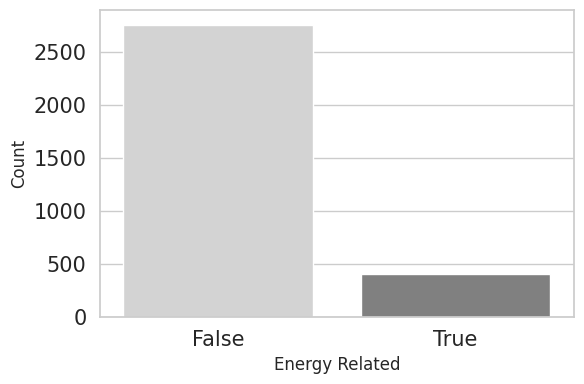

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# Filepath to the parsed JSON file (adjust if needed)
output_json_filepath = "malpedia_families_output.json"

# Load the parsed JSON data.
try:
    with open(output_json_filepath, 'r') as f:
        data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading parsed JSON: {e}")
    data = []

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Ensure the energy_related column is a boolean.
df["energy_related"] = df["energy_related"].astype(bool)

# Get the exact counts for True and False.
counts = df["energy_related"].value_counts()
print("Exact true counts:")
print(counts)

# Get the exact counts for True and False.
counts = df["energy_related"].value_counts()
print("Exact counts:")
print(counts)

# Compute and print percentages
total = counts.sum()
percentages = counts / total * 100
print("\nPercentages:")
print(percentages.apply(lambda x: f"{x:.2f}%"))

# Compute and print the difference
diff_pct = percentages[True] - percentages[False]
print(f"\nDifference (True − False): {diff_pct:.2f} percentage points")

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="energy_related", palette={"True": "grey", "False": "lightgrey"})
#plt.title("Number of Malware Families Identified as Energy Related")
plt.xlabel("Energy Related")
plt.ylabel("Count")
plt.xticks([0, 1], ["False", "True"])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("families_energy.pdf")
plt.show()


In [5]:
import json

# File paths (adjust as needed)
original_json_filepath = "malpedia_families.json"          # Original JSON with all malware family details
parsed_json_filepath = "malpedia_families_output.json"       # Parsed JSON with energy-related info
output_filtered_json_filepath = "energy_related_malpedia_families.json"  # Output JSON with only energy-related families

# ---------------------------
# Load the Original JSON Data
# ---------------------------
try:
    with open(original_json_filepath, 'r') as f:
        original_data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading original JSON data: {e}")
    original_data = {}

# ---------------------------
# Load the Parsed JSON Data
# ---------------------------
try:
    with open(parsed_json_filepath, 'r') as f:
        parsed_data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading parsed JSON data: {e}")
    parsed_data = []

# ---------------------------
# Build a Set of Keys for Energy-Related Families
# ---------------------------
# We assume each record in parsed_data has a "name" field corresponding to the key in original_data.
energy_related_keys = {
    record["name"] for record in parsed_data if record.get("energy_related") is True
}

print(f"Found {len(energy_related_keys)} energy-related families in parsed data.")

# ---------------------------
# Build a Mapping from Family Name to Energy Explanation
# ---------------------------
energy_explanation_map = {}
for record in parsed_data:
    # Only add records that are energy related and have an explanation.
    if record.get("energy_related") is True:
        energy_explanation_map[record["name"]] = record.get("energy_explanation", "")

# ---------------------------
# Filter the Original Data and Merge with Energy Explanation and Energy-Related Flag
# ---------------------------
filtered_data = {}
for key, value in original_data.items():
    if key in energy_related_keys:
        merged_record = value.copy()
        # Add the energy_explanation and explicitly set energy_related to True.
        merged_record["energy_explanation"] = energy_explanation_map.get(key, "")
        merged_record["energy_related"] = True
        filtered_data[key] = merged_record

print(f"Filtered data contains {len(filtered_data)} families.")

# ---------------------------
# Save the Filtered Data to a New JSON File
# ---------------------------
try:
    with open(output_filtered_json_filepath, 'w') as f:
        json.dump(filtered_data, f, indent=4)
    print(f"Filtered energy-related malware families written to {output_filtered_json_filepath}")
except Exception as e:
    print(f"Error writing filtered JSON data: {e}")


Found 407 energy-related families in parsed data.
Filtered data contains 407 families.
Filtered energy-related malware families written to energy_related_malpedia_families.json


In [6]:
import json

# File paths (adjust if needed)
input_filepath = "energy_related_malpedia_families-checked.json"
output_filepath = "energy_related_malpedia_families-checked-true.json"

# Load the manually checked JSON file.
try:
    with open(input_filepath, 'r') as f:
        data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading file {input_filepath}: {e}")
    data = {}

# Filter the data to only include records where "energy_related" is True.
# Handle both dictionary and list cases.
if isinstance(data, dict):
    filtered_data = {k: v for k, v in data.items() if v.get("energy_related") is True}
elif isinstance(data, list):
    filtered_data = [record for record in data if record.get("energy_related") is True]
else:
    filtered_data = data

# Save the filtered data to a new JSON file.
try:
    with open(output_filepath, 'w') as f:
        json.dump(filtered_data, f, indent=4)
    print(f"Filtered data written to {output_filepath}.")
except Exception as e:
    print(f"Error writing output JSON: {e}")


Filtered data written to energy_related_malpedia_families-checked-true.json.


In [7]:
import os
import json
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# ---------------------------
# Configuration and Globals
# ---------------------------
API_KEY = ''  # Replace with your actual VirusTotal API key
BASE_URL = 'https://www.virustotal.com/api/v3'
headers = {'x-apikey': API_KEY}

# File to store the VirusTotal responses
STORED_RESULTS_FILE = 'stored_results_iocs.json'
# Folder containing IOC JSON files (each file has a "files" list of hashes)
IOC_FOLDER = 'datasets/iocs'  # Adjust this folder path as needed

# Daily quota: 500 lookups per day; delay: 15 seconds per lookup (approx. 4 lookups/min)
DAILY_QUOTA = 500
DELAY_SECONDS = 15

# ---------------------------
# Helper Functions
# ---------------------------
def load_ioc_hashes_from_folder(folder_path: str) -> list:
    """
    Scan the specified folder for JSON files.
    Each JSON file is expected to have a "files" key containing a list of hashes.
    Returns a deduplicated list of all IOC hashes found.
    """
    all_hashes = set()
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                hashes = data.get("files", [])
                if isinstance(hashes, list):
                    for h in hashes:
                        all_hashes.add(str(h).strip())
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    return list(all_hashes)

def load_stored_results() -> dict:
    """Load stored VirusTotal results from a JSON file."""
    if os.path.exists(STORED_RESULTS_FILE):
        try:
            with open(STORED_RESULTS_FILE, 'r') as file:
                return json.load(file)
        except json.JSONDecodeError as e:
            print(f"Error decoding stored results: {e}")
            return {}
    return {}

def save_results_to_file(results: dict):
    """Save results to a JSON file."""
    with open(STORED_RESULTS_FILE, 'w') as file:
        json.dump(results, file, indent=4)

def search_file_hashes(hashes: list, stored_results: dict) -> dict:
    """
    Query the VirusTotal API for each hash not already in stored_results.
    Enforces a rate limit of 4 lookups per minute (15-second delay) and stops after 500 lookups.
    Saves the results immediately after processing each hash.
    """
    results = stored_results.copy()
    lookup_count = 0

    for file_hash in tqdm(hashes, desc="Querying VirusTotal", total=len(hashes)):
        if file_hash in results:
            continue  # Skip already processed hashes

        if lookup_count >= DAILY_QUOTA:
            print("Daily quota reached: 500 lookups performed. Stopping further queries.")
            break

        url = f'{BASE_URL}/files/{file_hash}'
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            try:
                data = response.json()
                results[file_hash] = data
            except json.JSONDecodeError:
                print(f"Error decoding JSON for hash: {file_hash}")
        else:
            print(f'Failed to retrieve data for hash: {file_hash} (HTTP {response.status_code})')

        lookup_count += 1
        save_results_to_file(results)  # Save after processing each hash.
        time.sleep(DELAY_SECONDS)  # Delay to satisfy rate limit

    return results

def analyze_results(results: dict) -> pd.DataFrame:
    """
    Process the VirusTotal results into a DataFrame.
    For each hash, extract detection information from the 'last_analysis_results' attribute.
    """
    analysis = []
    for file_hash, result in results.items():
        try:
            attributes = result['data']['attributes']
            last_analysis_results = attributes['last_analysis_results']
        except KeyError as e:
            print(f"Missing key for hash {file_hash}: {e}")
            continue

        for engine_name, engine_data in last_analysis_results.items():
            analysis.append({
                'file_hash': file_hash,
                'engine_name': engine_name,
                'category': engine_data.get('category', 'clean'),
                'result': engine_data.get('result', 'clean')
            })

    return pd.DataFrame(analysis)

def comparative_analysis(df: pd.DataFrame):
    """
    Compare detection performance between AI/ML-based and non-AI/ML-based antivirus engines.
    """
    # Mark engines as AI/ML-based if they are in the predefined list.
    df['is_ai_ml'] = df['engine_name'].isin([
        'Acronis',
        'BitDefender', 'BitDefenderFalx', 'BitDefenderTheta',
        'CrowdStrike',
        'Cybereason',
        'Cylance',
        'DeepInstinct',
        'Elastic',
        'Fortinet',
        'F-Secure',
        'SentinelOne',
        'Sophos',
        'Trapmine',
        'Webroot'
    ])

    detection_rate = df[df['category'] == 'malicious'].groupby('is_ai_ml').size() / df.groupby('is_ai_ml').size()
    print("Detection Rates:")
    print(detection_rate)

    plt.figure(figsize=(8, 6))
    detection_rate.plot(kind='bar', color=['orange', 'blue'], fontsize=12)
    plt.title('Normalized Detection Rate of AI/ML vs. Non-AI/ML Engines', fontsize=16)
    plt.xlabel('Engine Type', fontsize=14)
    plt.ylabel('Detection Rate (Malicious/Total)', fontsize=14)
    plt.xticks(ticks=[0, 1], labels=['Non-AI/ML', 'AI/ML'], rotation=0)
    plt.tight_layout()
    plt.savefig('normalized_detection_rate.png')
    plt.show()

    detection_distribution = df[df['category'] == 'malicious'].groupby(['engine_name', 'is_ai_ml']).size().reset_index(name='detection_count')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='is_ai_ml', y='detection_count', data=detection_distribution)
    plt.title('Distribution of Detection Counts Across Engines', fontsize=16)
    plt.xlabel('Engine Type (0 = Non-AI/ML, 1 = AI/ML)', fontsize=14)
    plt.ylabel('Detection Count', fontsize=14)
    plt.tight_layout()
    plt.savefig('detection_distribution.pdf')
    plt.show()

def specific_engine_analysis(df: pd.DataFrame):
    """
    Analyze performance for specific engines (e.g., SentinelOne and Acronis).
    """
    specific_engines = ['SentinelOne', 'Acronis']
    df_specific = df[df['engine_name'].isin(specific_engines)]
    if df_specific.empty:
        print("No data found for SentinelOne or Acronis engines.")
        return

    detection_rate_specific = df_specific[df_specific['category'] == 'malicious'].groupby('engine_name').size() / df_specific.groupby('engine_name').size()
    if detection_rate_specific.empty:
        print("No malicious detections found for SentinelOne or Acronis engines.")
    else:
        plt.figure(figsize=(10, 6))
        detection_rate_specific.plot(kind='bar', color='green', fontsize=12)
        plt.title('Detection Rate of Specific Engines (SentinelOne and Acronis)', fontsize=16)
        plt.xlabel('Engine Name', fontsize=14)
        plt.ylabel('Detection Rate (Malicious/Total)', fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=12)
        plt.tight_layout()
        plt.savefig('specific_engines_detection_rate.png')
        plt.show()

# ---------------------------
# Main Processing
# ---------------------------
# Step 1: Load all IOC hashes from the specified folder.
ioc_hashes = load_ioc_hashes_from_folder(IOC_FOLDER)
print(f"Found {len(ioc_hashes)} unique IOC hashes.")

# Step 2: Load any stored VirusTotal results.
#stored_results = load_stored_results()

# Step 3: Query VirusTotal for the hashes, saving dynamically and obeying rate limits.
#results = search_file_hashes(ioc_hashes, stored_results)

# Step 4: Save the updated results (should already be saved dynamically).
#save_results_to_file(results)

# Step 5: Analyze the results.
#df_analysis = analyze_results(results)

# Optional: Save the analysis DataFrame to CSV for further inspection.
#df_analysis.to_csv('analysis_results.csv', index=False)

# Step 6: Perform comparative analysis and produce plots.
#comparative_analysis(df_analysis)
#specific_engine_analysis(df_analysis)


Found 2419 unique IOC hashes.


Total detection records: 178105
Summary of Detection Rates (as a percentage of total records):
        engine_name  detection_rate
0        Acronis ML        0.001084
1    SentinelOne ML        0.005957
2  General (others)        0.475736
3             Total        0.482777


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/1403239370.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_df, x="engine_name", y="detection_rate", palette="viridis")


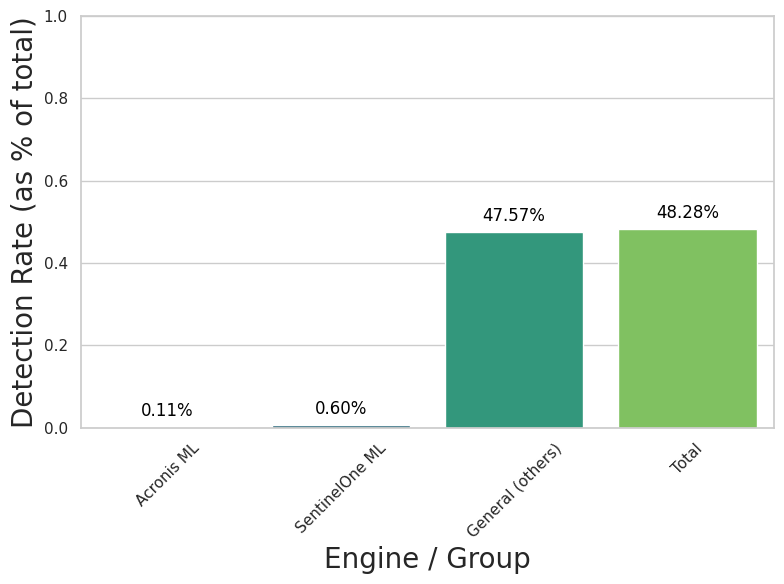

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for nicer plots.
sns.set_theme(style="whitegrid")

# Load the analysis results CSV.
csv_filepath = "analysis_results.csv"
df = pd.read_csv(csv_filepath)

# Total number of detection records (each row is one engine's result for a file)
total_detections = len(df)
print(f"Total detection records: {total_detections}")

# Calculate overall number of malicious detections across all engines.
total_malicious = (df["category"] == "malicious").sum()

# Calculate overall detection rate as percentage of total records.
overall_detection_rate = total_malicious / total_detections

# Define engines of interest.
engines_of_interest = ["Acronis", "SentinelOne"]

# For individual engines, calculate the number of malicious detections.
def engine_detection_rate(engine):
    df_engine = df[df["engine_name"] == engine]
    if len(df_engine) == 0:
        return 0
    return (df_engine["category"] == "malicious").sum() / total_detections

acronis_rate = engine_detection_rate("Acronis")
sentinelone_rate = engine_detection_rate("SentinelOne")

# For the general group, consider all engines not in the list.
df_general = df[~df["engine_name"].isin(engines_of_interest)]
general_rate = (df_general["category"] == "malicious").sum() / total_detections

# Create a summary DataFrame.
summary_df = pd.DataFrame({
    "engine_name": ["Acronis ML", "SentinelOne ML", "General (others)", "Total"],
    "detection_rate": [acronis_rate, sentinelone_rate, general_rate, overall_detection_rate]
})

print("Summary of Detection Rates (as a percentage of total records):")
print(summary_df)

# Plot the detection rates.
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=summary_df, x="engine_name", y="detection_rate", palette="viridis")
#plt.title("Detection Rate (Malicious/Total) by Engine Group", fontsize=16)
plt.xlabel("Engine / Group", fontsize=20)
plt.ylabel("Detection Rate (as % of total)", fontsize=20)
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its detection rate percentage.
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig("detection_rate_summary.png")
plt.show()


Summary of Detection Counts and Rates (per engine):
     engine_name  total_hashes  malicious_hashes  detection_rate
0          ALYac          2358            1516.0        0.642918
1           APEX          2364            1470.0        0.621827
2            AVG          2092            1581.0        0.755736
3         AVware             3               0.0        0.000000
4        Acronis          2368             193.0        0.081503
..           ...           ...               ...             ...
90  alibabacloud          1032             644.0        0.624031
91    androguard             6               0.0        0.000000
92       eGambit           423             109.0        0.257683
93       huorong           737             465.0        0.630936
94       tehtris          1911             116.0        0.060701

[95 rows x 4 columns]


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/2361503589.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary, x='engine_name', y='malicious_hashes', palette='viridis')


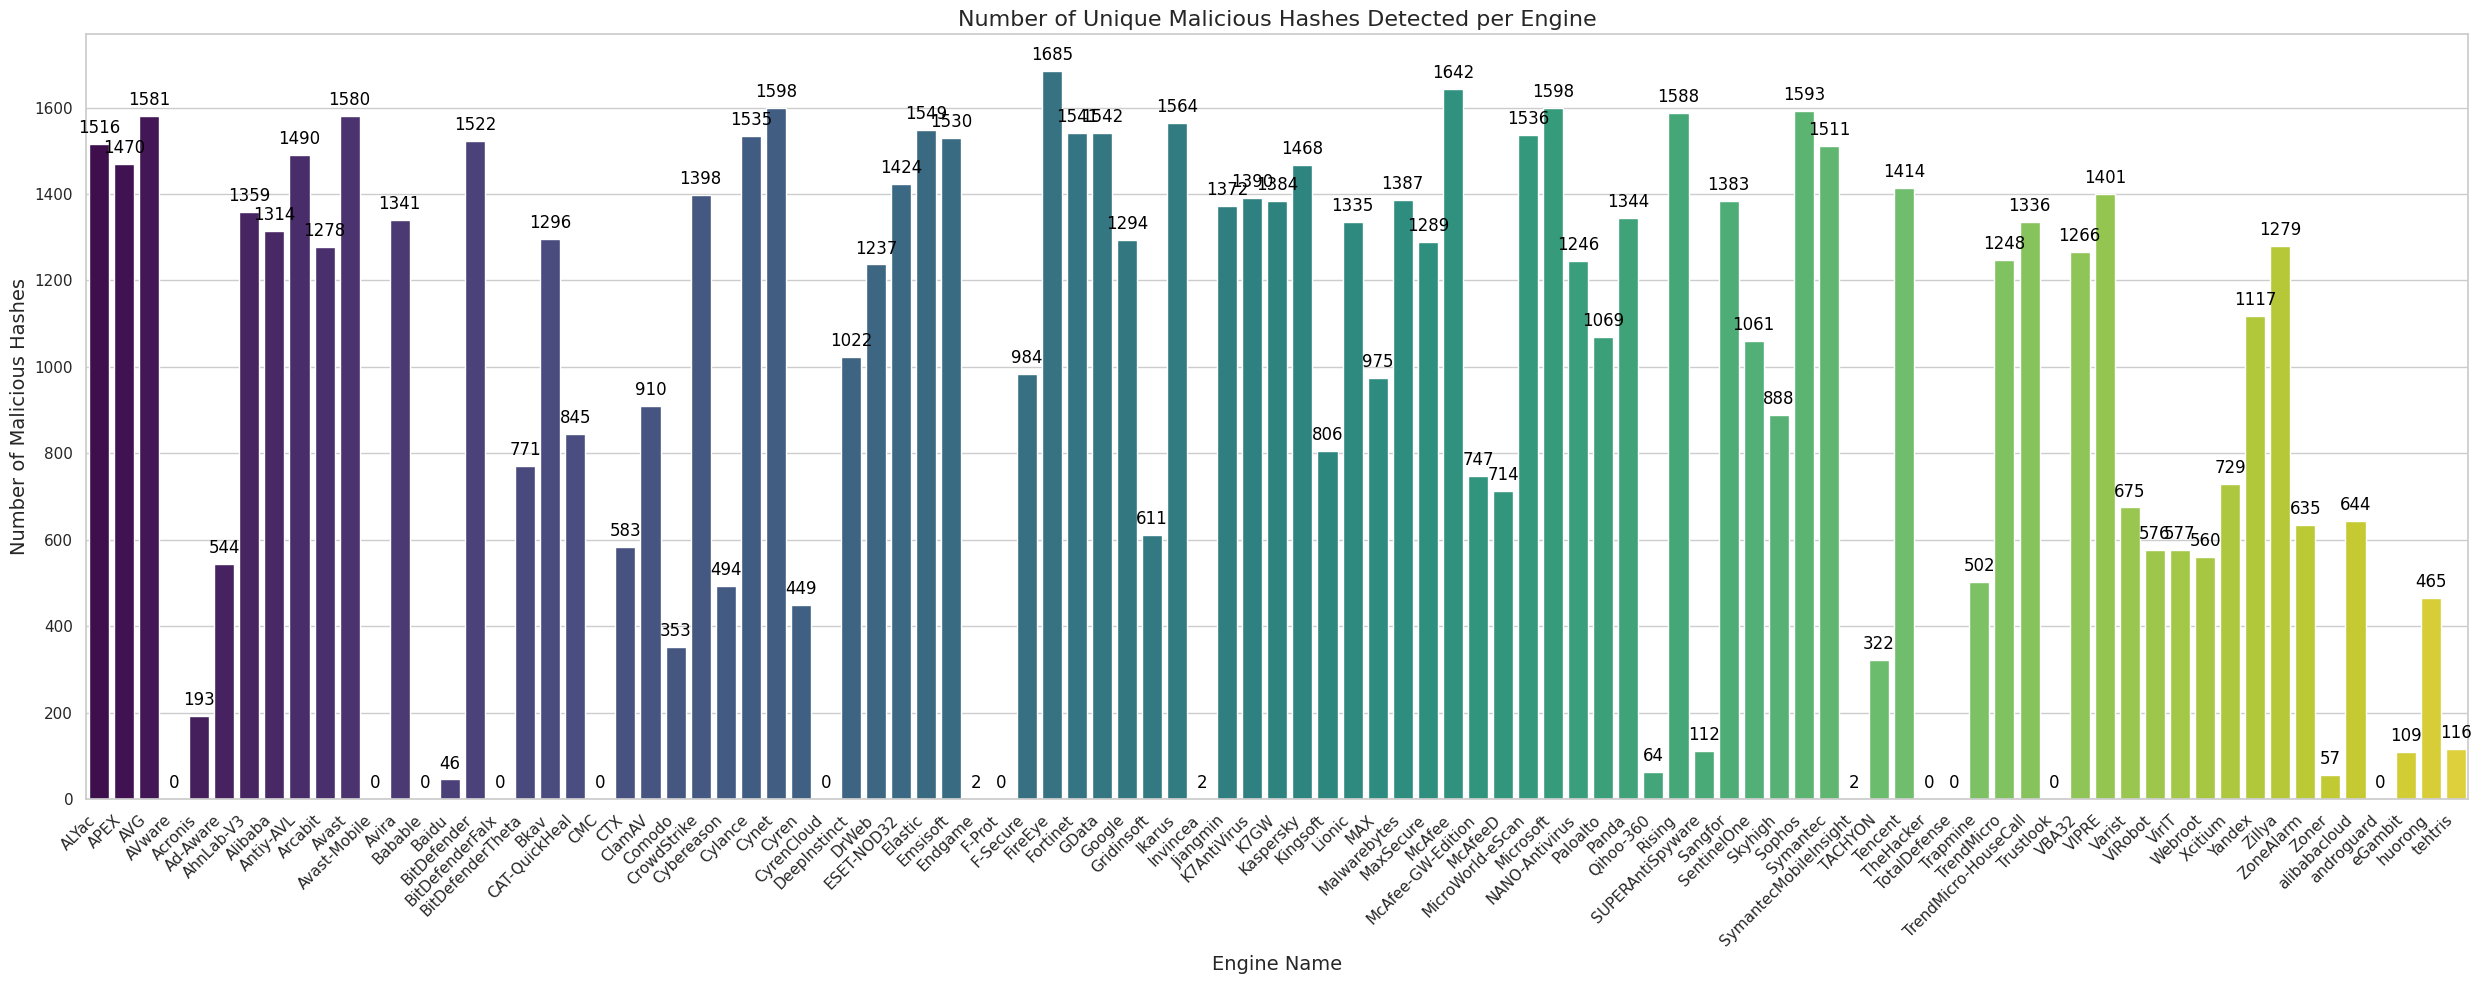

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a seaborn style for nicer plots.
sns.set_theme(style="whitegrid")

# Load your analysis results CSV file.
csv_filepath = "analysis_results.csv"
df = pd.read_csv(csv_filepath)

# Ensure that the file_hash and category columns exist.
# (Assuming each row represents an engine's analysis for a given file hash.)
if 'file_hash' not in df.columns or 'category' not in df.columns:
    raise ValueError("CSV must contain 'file_hash' and 'category' columns.")

# We'll consider a hash "detected" if the engine's category is "malicious".
# First, for each engine, count the number of unique file hashes processed.
total_hashes = df.groupby('engine_name')['file_hash'].nunique().reset_index(name='total_hashes')

# Then count the unique file hashes flagged as malicious by each engine.
malicious_hashes = df[df['category'] == 'malicious'].groupby('engine_name')['file_hash'].nunique().reset_index(name='malicious_hashes')

# Merge the two counts.
summary = pd.merge(total_hashes, malicious_hashes, on='engine_name', how='left')
summary['malicious_hashes'] = summary['malicious_hashes'].fillna(0)
summary['detection_rate'] = summary['malicious_hashes'] / summary['total_hashes']

print("Summary of Detection Counts and Rates (per engine):")
print(summary)

# Plot the number of malicious hashes for each engine.
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=summary, x='engine_name', y='malicious_hashes', palette='viridis')
plt.title("Number of Unique Malicious Hashes Detected per Engine", fontsize=16)
plt.xlabel("Engine Name", fontsize=14)
plt.ylabel("Number of Malicious Hashes", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the count.
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig("malicious_hashes_by_engine.png")
plt.show()


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/478841375.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("engine_name")
/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/478841375.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=engine_summary, x="label", y="detection_rate", palette={row['label']: ("red" if row['is_static_ml'] else "grey") for _, row in engine_summary.iterrows()})


Summary of Detection Rates:
     engine_name  detection_rate  is_static_ml             label  \
0          ALYac        0.642918         False         KR: ALYac   
1           APEX        0.621827         False          JP: APEX   
2            AVG        0.755736         False           CZ: AVG   
3         AVware        0.000000         False        DE: AVware   
4        Acronis        0.081503          True    USA: Acronis *   
..           ...             ...           ...               ...   
90  alibabacloud        0.624031         False  CN: alibabacloud   
91    androguard        0.000000         False     ?: androguard   
92       eGambit        0.257683         False       FR: eGambit   
93       huorong        0.630936         False       CN: huorong   
94       tehtris        0.060701         False       FR: tehtris   

    agg_general_detection_rate  
0                     0.488732  
1                     0.488732  
2                     0.488732  
3                     0

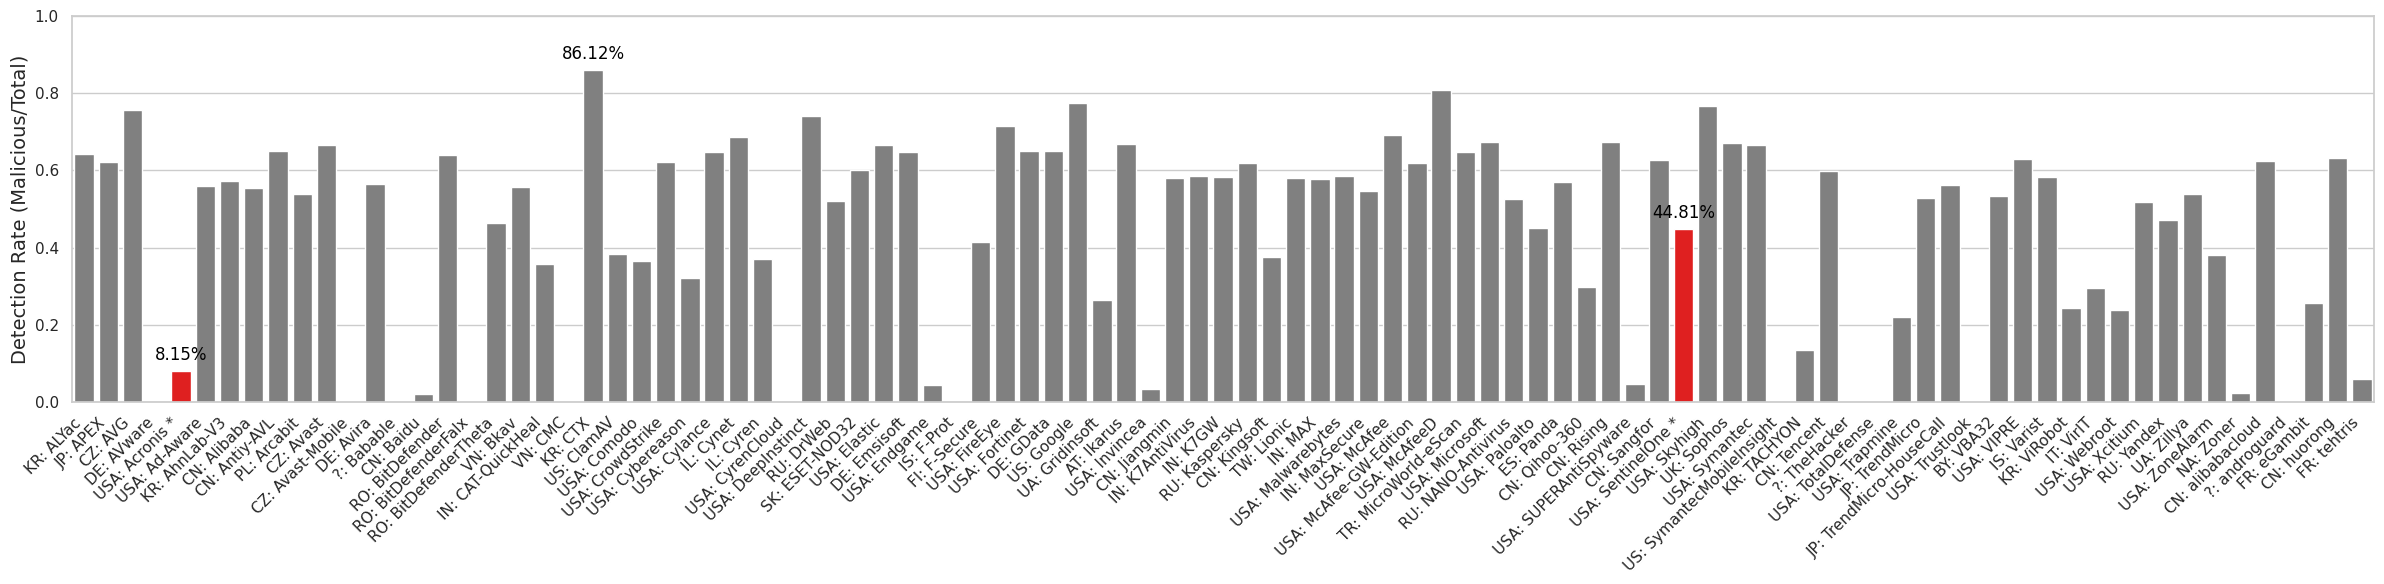

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style.
sns.set_theme(style="whitegrid")

# Load the analysis results CSV.
csv_filepath = "analysis_results.csv"
df = pd.read_csv(csv_filepath)

# Compute the detection rate for each engine.
# Detection rate = (# of rows with category == "malicious") / (total rows for that engine)
engine_summary = (
    df.groupby("engine_name")
    .apply(lambda x: (x["category"] == "malicious").sum() / len(x))
    .reset_index(name="detection_rate")
)

# Manually curated mapping of antivirus engine names to headquarters country acronyms.
hq_mapping_fallback = {
    "Bkav": "VN",
    "Lionic": "TW",
    "AVG": "CZ",
    "tehtris": "FR",
    "MicroWorld-eScan": "TR",
    "CMC": "VN",
    "CAT-QuickHeal": "IN",
    "McAfee": "USA",
    "Cylance": "USA",
    "VIPRE": "USA",
    "Sangfor": "CN",
    "K7AntiVirus": "IN",
    "BitDefender": "RO",
    "K7GW": "IN",
    "Cybereason": "USA",
    "Arcabit": "PL",
    "Baidu": "CN",
    "VirIT": "IT",
    "Cyren": "IL",
    "Elastic": "USA",
    "ESET-NOD32": "SK",
    "Cynet": "IL",
    "APEX": "JP",
    "Paloalto": "USA",
    "ClamAV": "US",
    "Kaspersky": "RU",
    "Alibaba": "CN",
    "NANO-Antivirus": "RU",
    "ViRobot": "KR",
    "Rising": "CN",
    "Ad-Aware": "USA",
    "TACHYON": "KR",
    "Sophos": "UK",
    "Comodo": "USA",
    "F-Secure": "FI",
    "DrWeb": "RU",
    "Zillya": "UA",
    "TrendMicro": "JP",
    "McAfee-GW-Edition": "USA",
    "Trapmine": "USA",
    "FireEye": "USA",
    "Emsisoft": "DE",
    "SentinelOne": "USA",
    "Jiangmin": "CN",
    "Webroot": "USA",
    "Avira": "DE",
    "Antiy-AVL": "CN",
    "Kingsoft": "CN",
    "Gridinsoft": "UA",
    "Microsoft": "USA",
    "SUPERAntiSpyware": "USA",
    "ZoneAlarm": "USA",
    "GData": "DE",
    "Google": "US",
    "AhnLab-V3": "KR",
    "Acronis": "USA",
    "VBA32": "BY",
    "ALYac": "KR",
    "MAX": "IN",
    "Malwarebytes": "USA",
    "Panda": "ES",
    "TrendMicro-HouseCall": "JP",
    "Tencent": "CN",
    "Yandex": "RU",
    "Ikarus": "AT",
    "MaxSecure": "IN",
    "Fortinet": "USA",
    "BitDefenderTheta": "RO",
    "Zoner": "NA",
    "Avast": "CZ",
    "CrowdStrike": "USA",
    "Symantec": "USA",
    "Trustlook": "USA",
    "SymantecMobileInsight": "US",
    "BitDefenderFalx": "RO",
    "Avast-Mobile": "CZ",
    "AVware":"DE",
    "Babable":"?",
    "CTX": "KR",
    "CyrenCloud":"USA",
    "DeepInstinct": "USA",
    "Endgame":"USA",
    "F-Prot":"IS",
    "Invincea":"USA",
    "McAfeeD": "USA",
    "Qihoo-360":"CN",
    "Skyhigh":"USA",
    "TheHacker":"?",
    "TotalDefense": "USA",
    "Varist":"IS",
    "Xcitium":"USA",
    "alibabacloud":"CN",
    "androguard":"?",
    "eGambit":"FR",
    "huorong":"CN"

    
    
    
    
    
    
    
    
}


# Define the two engines that explicitly use static ML.
static_ml_engines = ["Acronis", "SentinelOne"]

# Add a column indicating if an engine is static ML.
engine_summary["is_static_ml"] = engine_summary["engine_name"].isin(static_ml_engines)

# Create a new label that prepends the HQ acronym.
# For static ML engines, add an asterisk.
engine_summary["label"] = engine_summary.apply(
    lambda row: f"{hq_mapping_fallback.get(row['engine_name'], 'NA')}: {row['engine_name']}{' *' if row['is_static_ml'] else ''}",
    axis=1
)

# Compute the aggregated general detection rate for all engines that are not static ML.
general_df = df[~df["engine_name"].isin(static_ml_engines)]
if len(general_df) > 0:
    aggregated_rate = (general_df["category"] == "malicious").sum() / len(general_df)
else:
    aggregated_rate = 0

# Add a new column: For non-static ML engines, set it to the aggregated rate; for static ML engines, leave as NaN.
engine_summary["agg_general_detection_rate"] = engine_summary["engine_name"].apply(
    lambda x: aggregated_rate if x not in static_ml_engines else np.nan
)

print("Summary of Detection Rates:")
print(engine_summary)

# Plot the detection rates.
plt.figure(figsize=(24, 6))
ax = sns.barplot(data=engine_summary, x="label", y="detection_rate", palette={row['label']: ("red" if row['is_static_ml'] else "grey") for _, row in engine_summary.iterrows()})
#plt.title("Detection Rate by Antivirus Engine (with HQ Acronyms and Static ML Highlighted)", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("Detection Rate (Malicious/Total)", fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

# Annotate the bar for the top antivirus engine and the two ML-based ones with their percentage above the bar.
# Here, we decide the "top" antivirus engine as the one with the highest detection rate among all.
top_engine = engine_summary.loc[engine_summary["detection_rate"].idxmax(), "label"]

for p in ax.patches:
    height = p.get_height()
    label = p.get_x() + p.get_width()/2.
    engine_label = p.get_x()  # We'll compare using the text label from the x-tick positions.
    # Instead of comparing x positions, we can iterate over engine_summary rows.
    # Here, we annotate only if the engine is either the top engine or is in the static ML list.
    
for idx, row in engine_summary.iterrows():
    if (row["label"] == top_engine) or (row["is_static_ml"]):
        # Find the corresponding bar by matching label. We'll iterate over patches.
        # Since the order of patches corresponds to the order of the DataFrame's "label" column,
        # we can simply use idx.
        try:
            patch = ax.patches[idx]
            height = patch.get_height()
            patch_x = patch.get_x() + patch.get_width() / 2.
            ax.annotate(f'{height:.2%}', (patch_x, height),
                        ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')
        except IndexError:
            pass

plt.tight_layout()
plt.savefig("detection_rate_by_engine_with_static_ml.pdf")
plt.show()


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/3458785745.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ml_detected = grouped.apply(has_malicious_ml)
/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/3458785745.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_ml_detected = grouped.apply(has_malicious_non_ml)
/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/3458785745.py:39: Deprecat

Summary of IOC Detection Rates (percentage of total unique IOCs):
       Group  Percentage
0  Static ML   46.756529
1     Others   88.416175
2    Overall   88.416175


/scratch/slurm_tmpdir/job_1513728/ipykernel_1902480/3458785745.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Group", y="Percentage", data=summary, palette="Greys")


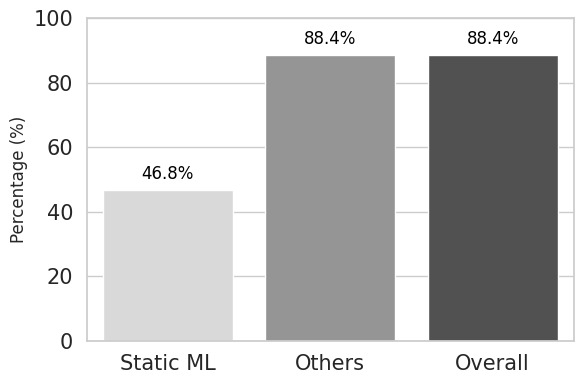

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for nicer plots.
sns.set_theme(style="whitegrid")

# Load the analysis results CSV.
csv_filepath = "analysis_results.csv"
df = pd.read_csv(csv_filepath)

# Ensure that we have the required columns: "file_hash", "engine_name", "category"
if not {"file_hash", "engine_name", "category"}.issubset(df.columns):
    raise ValueError("CSV must contain 'file_hash', 'engine_name', and 'category' columns.")

# Define the ML engines (those that use static ML).
ml_engines = ["Acronis", "SentinelOne"]

# Total number of unique IOC hashes.
total_iocs = df["file_hash"].nunique()

# Group by file_hash.
grouped = df.groupby("file_hash")

# For each file_hash group, check if at least one ML engine detected it as malicious.
def has_malicious_ml(group):
    return ((group["engine_name"].isin(ml_engines)) & (group["category"] == "malicious")).any()

# Check if at least one non-ML engine detected it as malicious.
def has_malicious_non_ml(group):
    return ((~group["engine_name"].isin(ml_engines)) & (group["category"] == "malicious")).any()

# Check if at least one engine (any) detected it as malicious.
def has_malicious_any(group):
    return (group["category"] == "malicious").any()

ml_detected = grouped.apply(has_malicious_ml)
non_ml_detected = grouped.apply(has_malicious_non_ml)
any_detected = grouped.apply(has_malicious_any)

# Compute percentages.
ml_percent = ml_detected.sum() / total_iocs * 100
non_ml_percent = non_ml_detected.sum() / total_iocs * 100
any_percent = any_detected.sum() / total_iocs * 100

# Create a summary DataFrame.
summary = pd.DataFrame({
    "Group": ["Static ML", "Others", "Overall"],
    "Percentage": [ml_percent, non_ml_percent, any_percent]
})

print("Summary of IOC Detection Rates (percentage of total unique IOCs):")
print(summary)

# Plot the summary.
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="Group", y="Percentage", data=summary, palette="Greys")
#plt.title("Percentage of IOCs Detected as Malicious")
plt.ylabel("Percentage (%)")
plt.xlabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 100)
plt.xticks(rotation=0)

# Annotate each bar with the percentage.
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig("ioc_detection_rate_comparison.pdf")
plt.show()

